In [1]:
# 收在下布林，且下影線大於實體Ｋ及上影線，加入EMA
# ! conda install -c conda-forge ta --yes
# ! conda update -c conda-forge ta --yes

In [2]:
import websocket
import requests
import json
import pandas as pd
import ta
import matplotlib.pyplot as plt
import math
import datetime as dt
import numpy as np
import time

In [3]:
timezone = 8
endpoint = 'wss://stream.binance.com:9443/ws'
symbol = 'ethusdt'
symbol_C = symbol.upper()
interval = '1h'

# start epoch till now
start_time = 1672535100000
end_time = round(time.time() * 1000)
# end_time = 1672556207000

# step between timestamps in milliseconds
step = 60000 * 3600

In [4]:
def get_historical(symbol, interval, start_time, end_time, step):
    
    rawdf = pd.DataFrame()
    
    url = "https://api.binance.com/api/v3/klines"
    
    for timestamp in range(start_time, end_time, step):
        params = {"symbol": symbol_C,
                  "interval": interval,
                  "startTime": timestamp,
                  "endTime": timestamp + step}
        response = requests.get(url, params=params).json()
        out = pd.DataFrame(response, columns = ["Open time", "Open", "High", "Low", "Close",
                                               "Volume", "Close_Time", "Quote asset volume",
                                               "Number of trades", "Taker buy base asset volume",
                                               "Taker buy quote asset volume", "Ignore"])
        rawdf = pd.concat([rawdf, out], axis = 0)
    
    rawdf = rawdf[['Close_Time', 'Open', 'Close', "High", "Low", 'Volume']]
    convert_dict = {'Close_Time': float, 'Open': float, 'Close': float, "High": float, "Low": float, 'Volume': float}
    rawdf = rawdf.astype(convert_dict)
    
    rawdf['Close_Time'] = pd.to_datetime(rawdf['Close_Time'], unit = 'ms')
    rawdf['Close_Time'] = rawdf['Close_Time'] + pd.Timedelta(hours=timezone)
    rawdf['Close_Time'] = rawdf['Close_Time'].dt.strftime('%Y-%m-%d %H:%M:%S')
    
    rawdf = rawdf.reset_index(drop=True)
    
    return rawdf

In [5]:
rawdf = get_historical(symbol, interval, start_time, end_time, step)
print(rawdf)

               Close_Time     Open    Close     High      Low      Volume
0     2023-01-01 10:59:59  1196.01  1195.40  1196.74  1194.11   3752.0476
1     2023-01-01 11:59:59  1195.41  1194.04  1195.41  1191.71   7493.4207
2     2023-01-01 12:59:59  1194.05  1192.92  1194.05  1190.57   6409.2491
3     2023-01-01 13:59:59  1192.92  1194.54  1194.67  1192.71   2316.3448
4     2023-01-01 14:59:59  1194.55  1194.81  1195.23  1193.81   4102.0957
...                   ...      ...      ...      ...      ...         ...
2018  2023-03-26 13:59:59  1749.11  1753.24  1754.43  1746.17   5931.7888
2019  2023-03-26 14:59:59  1753.23  1751.91  1755.72  1750.41   6728.6661
2020  2023-03-26 15:59:59  1751.92  1752.55  1755.46  1751.30   9590.0021
2021  2023-03-26 16:59:59  1752.55  1774.75  1787.64  1749.80  36934.3846
2022  2023-03-26 17:59:59  1774.75  1774.60  1782.16  1771.14  18407.6230

[2023 rows x 6 columns]


In [6]:
df = rawdf.copy()

In [7]:
def indicators(df):
#     sma
    sma_int = 30
    df['sma'] = ta.trend.sma_indicator(df.Close, window=sma_int)
#     bband
    bb_int = 30
    bb_dev = 2
    bb = ta.volatility.BollingerBands(df['Close'], window=bb_int, window_dev=bb_dev)
    df['bb_u'] = bb.bollinger_hband()
    df['bb_m'] = bb.bollinger_mavg()
    df['bb_l'] = bb.bollinger_lband()
#     rsi
    rsi_int = 14
    df['rsi'] = ta.momentum.RSIIndicator(df['Close'], window = rsi_int).rsi()
#     ema
    ema_int = 200
    df['ema'] = ta.trend.ema_indicator(df.Close, window=ema_int)
    return df

In [8]:
indicators(df)

,Close_Time,Open,Close,High,Low,Volume,sma,bb_u,bb_m,bb_l,rsi,ema
0,2023-01-01 10:59:59,1196.01,1195.40,1196.74,1194.11,3752.0476,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-01-01 11:59:59,1195.41,1194.04,1195.41,1191.71,7493.4207,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-01-01 12:59:59,1194.05,1192.92,1194.05,1190.57,6409.2491,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-01-01 13:59:59,1192.92,1194.54,1194.67,1192.71,2316.3448,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-01-01 14:59:59,1194.55,1194.81,1195.23,1193.81,4102.0957,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2018,2023-03-26 13:59:59,1749.11,1753.24,1754.43,1746.17,5931.7888,1746.953000,1764.276596,1746.953000,1729.629404,53.064244,1750.038489
2019,2023-03-26 14:59:59,1753.23,1751.91,1755.72,1750.41,6728.6661,1746.805667,1763.881165,1746.805667,1729.730169,52.056666,1750.057111
2020,2023-03-26 15:59:59,1751.92,1752.55,1755.46,1751.30,9590.0021,1746.761333,1763.769907,1746.761333,1729.752759,52.523826,1750.081915
2021,2023-03-26 16:59:59,1752.55,1774.75,1787.64,1749.80,36934.3846,1747.297667,1766.629314,1747.297667,1727.966019,65.193279,1750.327369


In [9]:
def conditions(df):

    # c1 下影線 大於 實體Ｋ & 下影線 大於 上影線
    # c1_1 紅Ｋ
    # c1_2 綠Ｋ
    # c2 收盤 小於 布林下
    # c3 ema 200

    for index, row in df.iterrows():
        # c1 red candle
        df['c1_1'] = (df['Open'] > df['Close']) & (abs(df['Low'] - df['Close']) > abs(df['Open'] - df['Close'])) & (abs(df['Low'] - df['Close']) > abs(df['High'] - df['Open']))
        # c1 green candle
        df['c1_2'] = (df['Close'] > df['Open']) & (abs(df['Low'] - df['Open']) > abs(df['Open'] - df['Close'])) & (abs(df['Low'] - df['Open']) > abs(df['High'] - df['Close']))
        # c2
        df['c2'] = df['Close'] < df['bb_l']
        # c3
        df['c3'] = df['Close'] <= df['ema']

    # 條件達成
    df['signal'] = False
    df.loc[(df['c1_1'] | df['c1_2']) & df.c2 & df.c3, 'signal'] = True


    # 下一根進場
    df['openbuy'] = False
    for i in range(len(df) - 1):
        if df.loc[i, 'signal'] == True:
            df.loc[i + 1, 'openbuy'] = True
#     print(df[df['Close_Time'].str.contains('2023-03-11 16')])
    
    return df

In [10]:
conditions(df)

,Close_Time,Open,Close,High,Low,Volume,sma,bb_u,bb_m,bb_l,rsi,ema,c1_1,c1_2,c2,c3,signal,openbuy
0,2023-01-01 10:59:59,1196.01,1195.40,1196.74,1194.11,3752.0476,NaN,NaN,NaN,NaN,NaN,NaN,True,False,False,False,False,False
1,2023-01-01 11:59:59,1195.41,1194.04,1195.41,1191.71,7493.4207,NaN,NaN,NaN,NaN,NaN,NaN,True,False,False,False,False,False
2,2023-01-01 12:59:59,1194.05,1192.92,1194.05,1190.57,6409.2491,NaN,NaN,NaN,NaN,NaN,NaN,True,False,False,False,False,False
3,2023-01-01 13:59:59,1192.92,1194.54,1194.67,1192.71,2316.3448,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False
4,2023-01-01 14:59:59,1194.55,1194.81,1195.23,1193.81,4102.0957,NaN,NaN,NaN,NaN,NaN,NaN,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018,2023-03-26 13:59:59,1749.11,1753.24,1754.43,1746.17,5931.7888,1746.953000,1764.276596,1746.953000,1729.629404,53.064244,1750.038489,False,False,False,False,False,False
2019,2023-03-26 14:59:59,1753.23,1751.91,1755.72,1750.41,6728.6661,1746.805667,1763.881165,1746.805667,1729.730169,52.056666,1750.057111,False,False,False,False,False,False
2020,2023-03-26 15:59:59,1751.92,1752.55,1755.46,1751.30,9590.0021,1746.761333,1763.769907,1746.761333,1729.752759,52.523826,1750.081915,False,False,False,False,False,False
2021,2023-03-26 16:59:59,1752.55,1774.75,1787.64,1749.80,36934.3846,1747.297667,1766.629314,1747.297667,1727.966019,65.193279,1750.327369,False,False,False,False,False,False


In [11]:
buydf = conditions(df)

# 進出場

in_position = False
stop_loss = np.nan

for index, row in buydf.iterrows():

    if index == 0:
        continue
        
        # set entry price (前一根Ｋ收盤價進場)
        # set stop loss (前一根Ｋ線低點停損)
        # 進場
    elif buydf.at[index, 'openbuy'] == True:
        close_val = buydf['Close']
        low_val = buydf['Low']
        buydf.at[index, 'entry_p'] = close_val.shift(1).at[index]
        buydf.at[index, 'stop_loss'] = low_val.shift(1).at[index]
        buydf.at[index, 'position'] = 'Buy'
        in_position = True
        stop_loss = low_val.shift(1).at[index]
    

    # 吃筍
    #-----------------------------重要-----------------------------
    # 若用 if 寫，則有可能入場馬上吃筍，若用 elif 則一個 iteration 只會執行一次
    elif in_position == True and buydf.at[index, 'Close'] < stop_loss:
        buydf.at[index, 'position'] = 'Stop'
        in_position = False
        stop_loss = np.nan

    # set take profit （高點碰到上布林，即刻出場）
    elif buydf.at[index, 'High'] >= buydf.at[index, 'bb_u'] and in_position == True:

        buydf.at[index, 'position'] = 'Sell'
        in_position = False
        stop_loss = np.nan

raw_entry_df = buydf.copy()

# 過濾有訊號或事件發生的Ｋ線
buydf = buydf[(buydf['openbuy'] == True) |
              (buydf['signal'] == True) | 
              (buydf['position'] == 'Buy') |
              (buydf['position'] == 'Sell') |
              (buydf['position'] == 'Stop')]


print(buydf)


               Close_Time     Open    Close     High      Low       Volume  \
573   2023-01-25 07:59:59  1562.17  1555.97  1565.27  1544.69   46525.4559   
574   2023-01-25 08:59:59  1555.97  1548.88  1557.00  1541.53   42208.8517   
575   2023-01-25 09:59:59  1548.89  1535.00  1550.47  1518.00   67088.1066   
576   2023-01-25 10:59:59  1534.99  1540.87  1543.06  1534.21   13866.2509   
595   2023-01-26 05:59:59  1580.69  1618.18  1624.13  1571.29   57333.1495   
857   2023-02-06 03:59:59  1615.69  1619.48  1622.10  1609.30   17751.2461   
858   2023-02-06 04:59:59  1619.48  1619.11  1623.18  1614.56    9620.6454   
859   2023-02-06 05:59:59  1619.10  1622.20  1622.22  1611.80   10420.2343   
878   2023-02-07 00:59:59  1649.00  1644.89  1658.56  1639.81   36631.3882   
938   2023-02-09 12:59:59  1619.05  1623.85  1627.31  1610.22   26313.3341   
939   2023-02-09 13:59:59  1623.84  1628.39  1630.69  1622.29   20128.2083   
953   2023-02-10 03:59:59  1621.85  1579.81  1622.86  1560.47   

In [12]:
# 部位回測

posdf = buydf.copy()
posdf = posdf.reset_index(drop = True)
posdf = posdf[(posdf['position'] == 'Buy') |
              (posdf['position'] == 'Sell') |
              (posdf['position'] == 'Stop')]

# 一次進場多少單位
pos_size = 1

col = ['Close_Time', 'Open', 'Close', 'High', 'Low', 'sma', 'bb_u', 'bb_l', 'rsi', 'position','entry_p', 'stop_loss']
pos = posdf[col]
pos = pos.reset_index(drop = True)


for index, row in pos.iterrows():
    
    current_pos = 0
    
    # 進場
    if pos.at[index, 'position'] == 'Buy':
        pos.at[index, 'size'] = pos_size
        pos.exit_p = np.nan
    
    # 出場
    if pos.at[index, 'position'] == 'Sell' or pos.at[index, 'position'] == 'Stop':
        
        #-----------------------------重要-----------------------------
        # 實戰需即刻出場
        
        # 停利：打到上布林
        if pos.at[index, 'position'] == 'Sell':
            pos.at[index, 'exit_p'] = pos.at[index, 'bb_u'] * 1

        # 停損：打到進場停損點（往回跌代，直到最近的'Buy'及其'stop_loss'）
        if pos.at[index, 'position'] == 'Stop':
            for i in range(index -1, -1, -1):
                if pos.at[i, 'position'] == 'Buy':
                    pos.at[index, 'exit_p'] = pos.at[i, 'stop_loss']
                break

        # 計算每次出場部位大小（每次出場皆清倉）
        for i in range(index -1, -1, -1):
            if pos.at[i, 'position'] == 'Buy':
                current_pos += pos.at[i, 'size']
                if i == 0:
                    pos.at[index, 'size'] = -current_pos
                else:
                    continue
            else:
                pos.at[index, 'size'] = -current_pos
                current_pos = 0
                break


# 計算部位價值
for index, row in pos.iterrows():
    if pos.at[index, 'position'] == 'Buy':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'entry_p'], 4)
    elif pos.at[index, 'position'] == 'Sell' or pos.at[index, 'position'] == 'Stop':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'exit_p'], 4)


# 若最後一筆為 Buy，移除該單，迭代驗證
for index, row in pos.iloc[::-1].iterrows():
    if row['position'] == 'Buy':
        pos = pos.drop(index)
    else:
        break
        
print(pos)
pos.to_csv('pos.csv')


# 手續費、滑點、價差
fee = 0.075 / 100
amt_abs_sum = pos.amt.abs().sum()
ttl_fee = amt_abs_sum * fee

# 損益
leverage = 10
ttl_profit = -pos.amt.sum() - ttl_fee


# 計算進場最大部位來代表總進場成本，以計算報酬率
pos['consec_entry'] = (pos['position'] != pos['position'].shift()).cumsum()
group_consec = pos.groupby('consec_entry').apply(lambda x:x.loc[x['position'] == 'Buy', 'amt' ].sum())
max_entry = group_consec.max()

profit_per = "{:.2f}%".format(ttl_profit / (max_entry/leverage) * 100)

wins = df['position'].str.count('Sell').sum()
loses = df['position'].str.count('Stop').sum()
win_rate = "{:.2f}%".format(wins / (wins + loses) * 100)

result = {'Profit': [round(ttl_profit, 2)],
          'Fee': [round(ttl_fee, 2)],
          'Max_Entry': [round(max_entry, 2)],
          'Profit_%': [profit_per],
          'Win_Rate': [win_rate]}


result_df = pd.DataFrame(result)

print(result_df)



             Close_Time     Open    Close     High      Low          sma  \
0   2023-01-25 08:59:59  1555.97  1548.88  1557.00  1541.53  1618.827000   
1   2023-01-25 09:59:59  1548.89  1535.00  1550.47  1518.00  1615.997667   
2   2023-01-25 10:59:59  1534.99  1540.87  1543.06  1534.21  1612.866667   
3   2023-01-26 05:59:59  1580.69  1618.18  1624.13  1571.29  1565.967000   
4   2023-02-06 04:59:59  1619.48  1619.11  1623.18  1614.56  1659.713667   
5   2023-02-06 05:59:59  1619.10  1622.20  1622.22  1611.80  1657.788000   
6   2023-02-07 00:59:59  1649.00  1644.89  1658.56  1639.81  1633.055000   
7   2023-02-09 13:59:59  1623.84  1628.39  1630.69  1622.29  1660.248667   
8   2023-02-10 03:59:59  1621.85  1579.81  1622.86  1560.47  1637.584000   
9   2023-02-10 05:59:59  1577.10  1540.55  1578.07  1524.40  1630.693667   
10  2023-02-10 06:59:59  1540.56  1537.99  1550.26  1527.93  1626.844333   
11  2023-02-10 07:59:59  1537.99  1545.35  1549.98  1537.08  1623.113000   
12  2023-02-

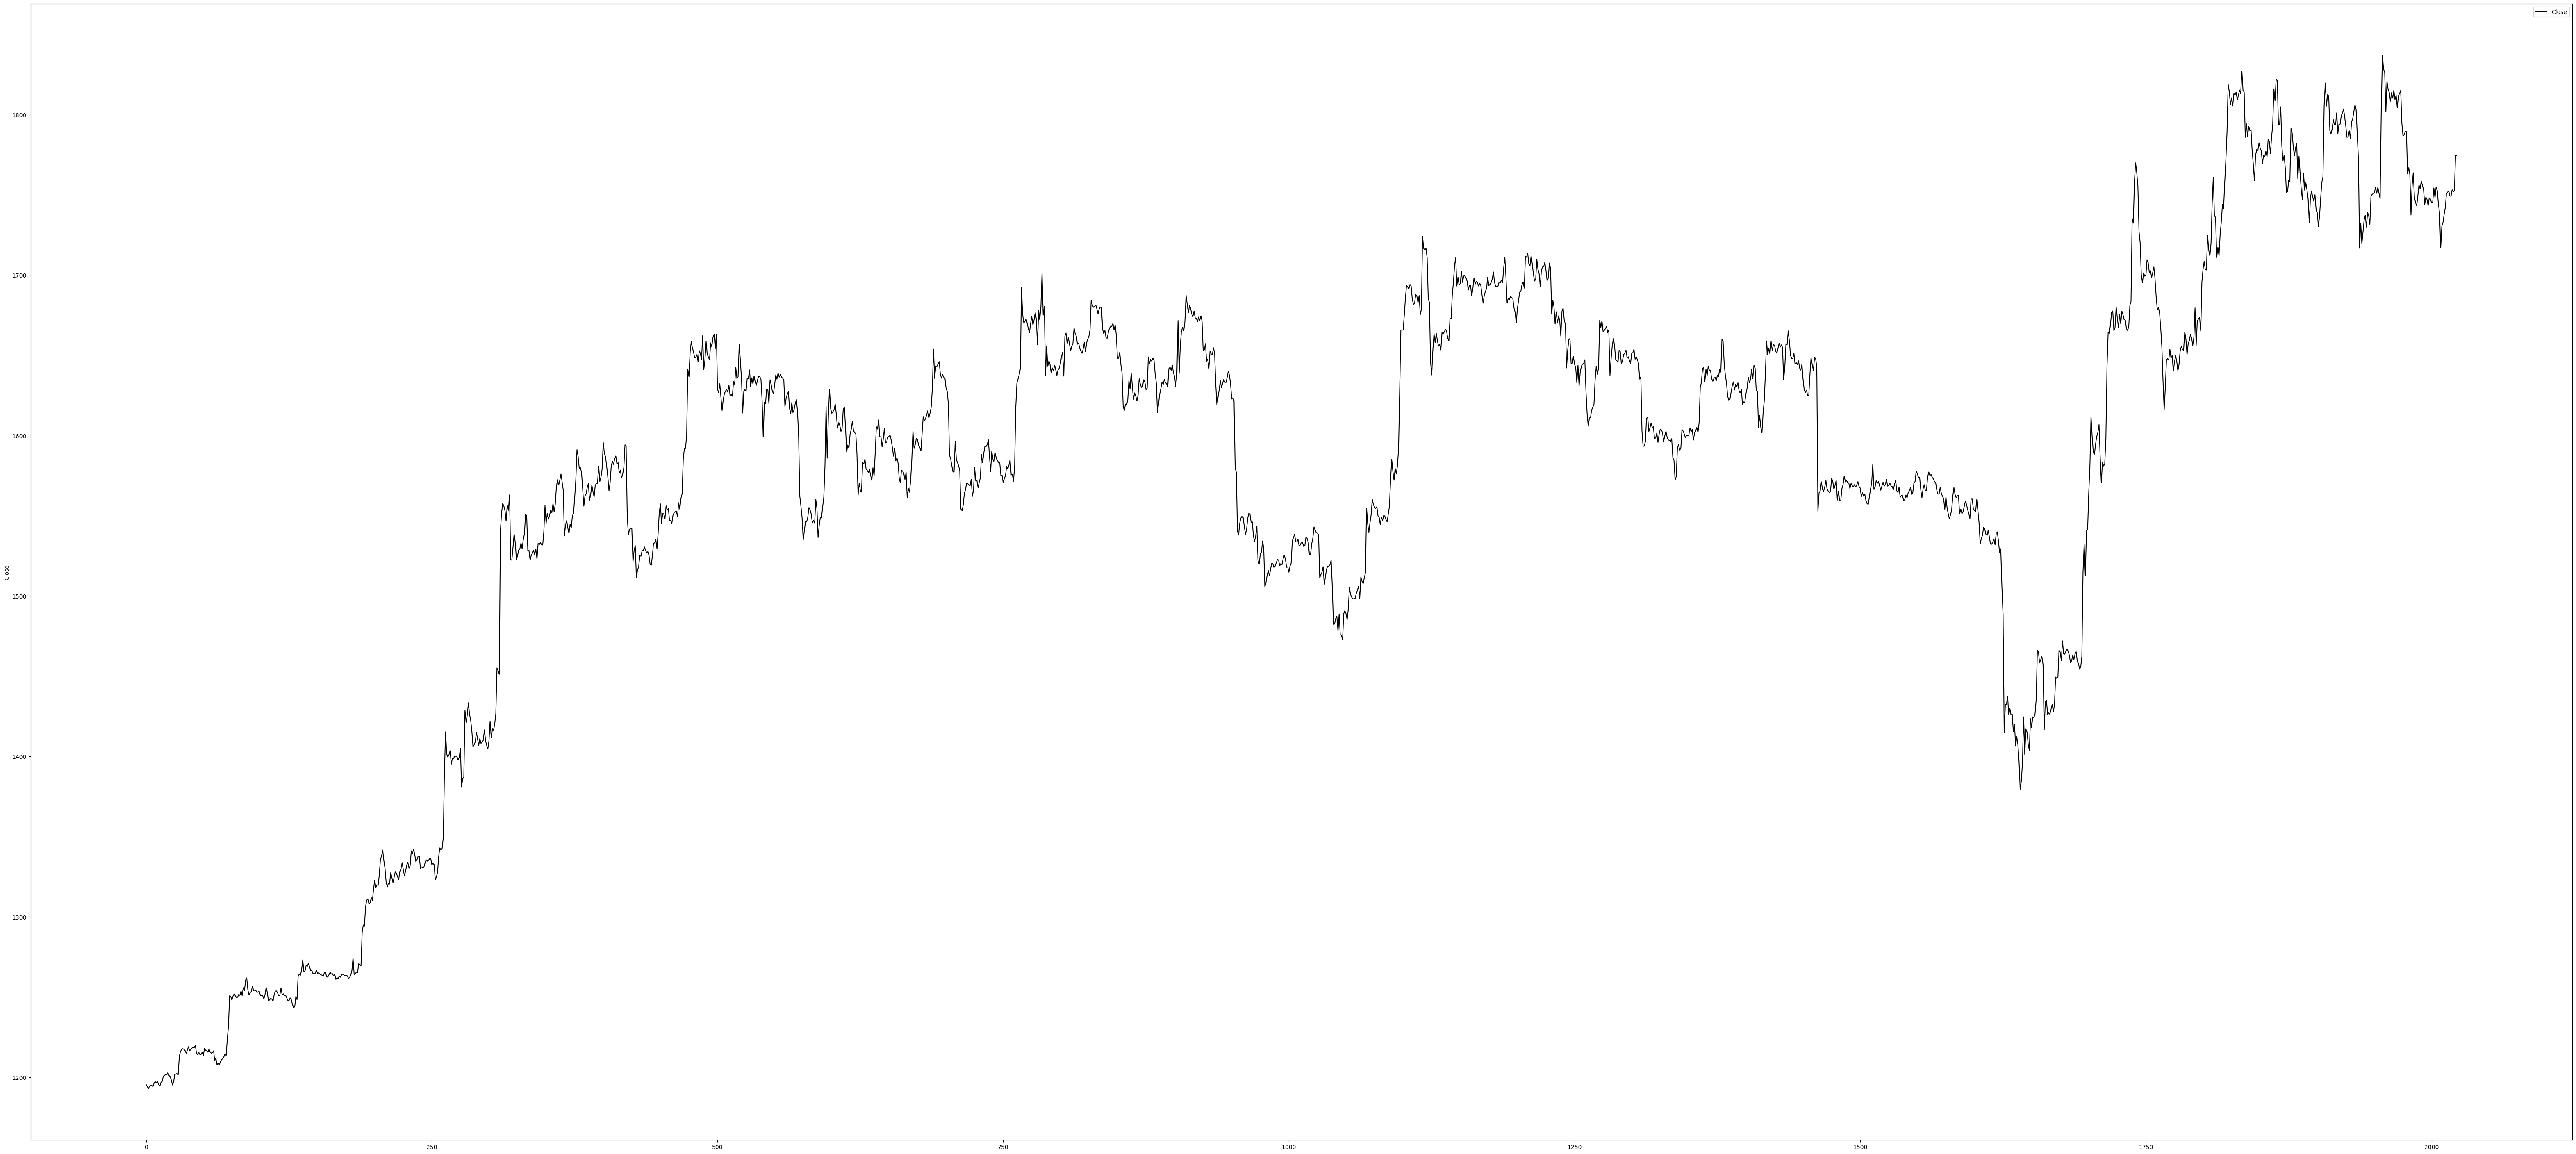

In [15]:
plt_df = raw_entry_df.copy()

plt.figure(figsize=(80, 36))
plt.ylabel('Close')
plt.plot(plt_df.Close, label = 'Close', c ='black')
for i in range(len(plt_df)):
    if plt_df.position[i] == 'Sell':
        plt.plot(i, plt_df.entry_p[i], 'go', label='_', markersize=20)
    elif plt_df.position[i] == 'Stop':
        plt.plot(i, plt_df.entry_p[i], 'ro', label='_', markersize=20)

plt.legend()
plt.show()